In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_predictions(model, split):
    pred_path = f"../results/{model}/{split}/test_predict.csv"
    raw_path = f"../data/{split}/raw/raw_test.csv"

    df_pred = pd.read_csv(pred_path)
    df_raw = pd.read_csv(raw_path)

    y_true = df_raw["permeability"]
    y_pred = df_pred["predict_permeability"]
    return y_true, y_pred, df_raw

def plot_prediction(ax, y_true, y_pred, title_suffix=""):
    sns.scatterplot(x=y_true, y=y_pred, ax=ax, s=20, alpha=0.7)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=1)
    mse = mean_squared_error(y_true, y_pred)
    ax.set_title(f"{title_suffix}\nMSE = {mse:.2f}")

def plot_grouped_by_monomer(ax, y_true, y_pred, num_monomers, title_suffix=""):
    unique_monomers = num_monomers.unique()
    for monomer in unique_monomers:
        mask = num_monomers == monomer
        sns.scatterplot(x=y_true[mask], y=y_pred[mask], ax=ax, label=f"{monomer}", s=20, alpha=0.7)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=1)
    ax.set_xlim(-10, -4)
    ax.set_ylim(-10, -4)
    ax.legend(title="# of monomers", loc="lower left", title_fontsize=7, fontsize=7)

# Data

In [3]:
model_list = ["baseline","MLP 2D fingerprint", "MLP 3D fingerprint", "Graph 2D", "Graph 3D SchNet"]
split_list = ["random split","monomer-based split", "stratified monomer-based split"]

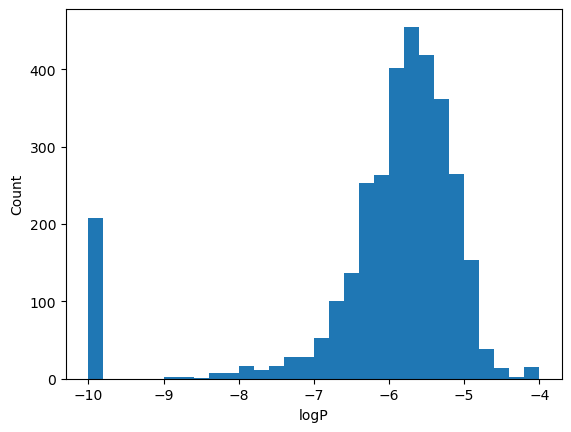

In [4]:
df = pd.read_csv("../results/permeability.csv")
plt.hist(df['permeability'],bins = 30)
plt.xlabel("logP")
plt.ylabel("Count")
plt.show()

# Results

In [5]:
# --- Metric Summary Table ---
results = []
for model in model_list:
    for split in split_list:
        y_true, y_pred, _ = load_predictions(model, split)
        results.append({
            "Model": model,
            "Split": split,
            "MSE": mean_squared_error(y_true, y_pred),
            "R2 Score": r2_score(y_true, y_pred)
        })

results_df = pd.DataFrame(results)
results_df

,Model,Split,MSE,R2 Score
0,baseline,random split,0.477743,-0.197663
1,baseline,monomer-based split,0.671564,-1.727586
2,baseline,stratified monomer-based split,0.392984,-0.159961
3,MLP 2D fingerprint,random split,0.200214,0.498080
4,MLP 2D fingerprint,monomer-based split,0.340986,-0.384930
5,MLP 2D fingerprint,stratified monomer-based split,0.186514,0.449471
6,MLP 3D fingerprint,random split,0.217991,0.453513
7,MLP 3D fingerprint,monomer-based split,0.218631,0.112020
8,MLP 3D fingerprint,stratified monomer-based split,0.191527,0.434675
9,Graph 2D,random split,0.263479,0.339480


# MSE by number of monomer

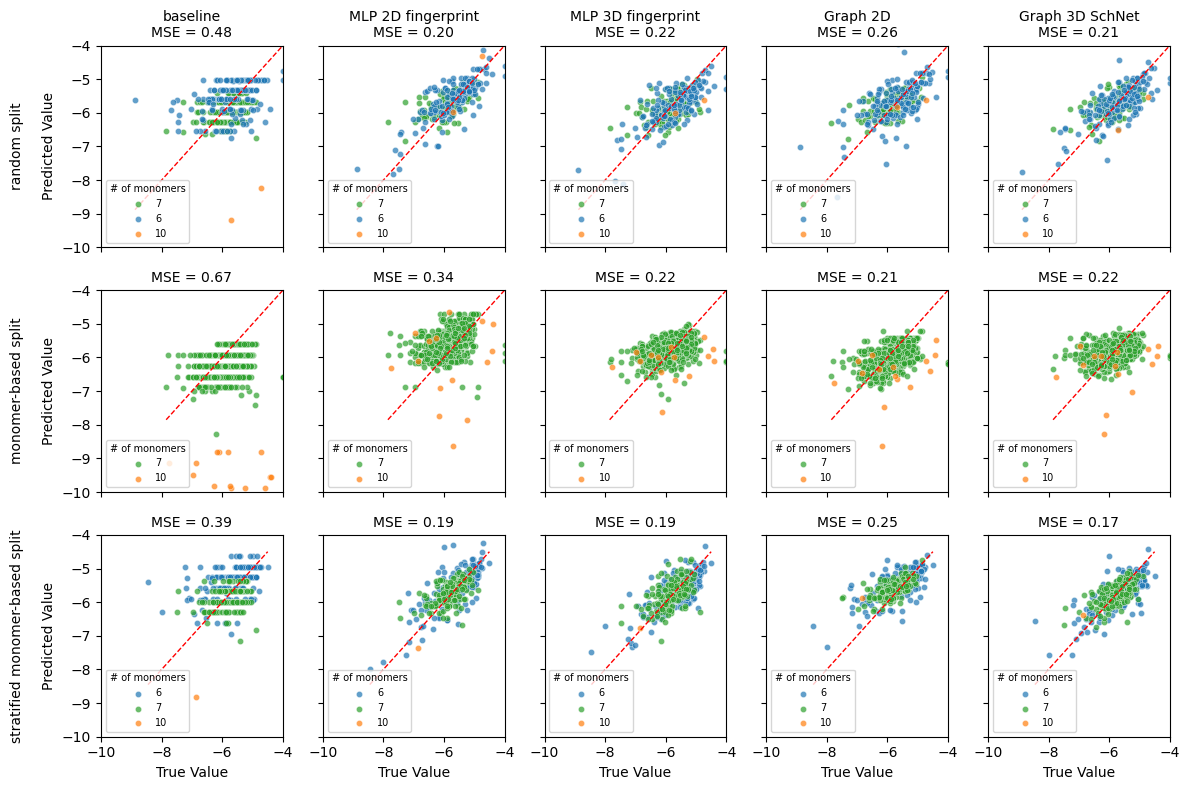

In [6]:
def plot_grouped_by_monomer(ax, y_true, y_pred, num_monomers, color_map, title_suffix=""):
    unique_monomers = num_monomers.unique()
    for monomer in unique_monomers:
        mask = num_monomers == monomer
        sns.scatterplot(
            x=y_true[mask],
            y=y_pred[mask],
            ax=ax,
            label=f"{monomer}",
            s=20,
            alpha=0.7,
            color=color_map.get(monomer, "gray")  # fallback color
        )
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=1)
    ax.set_xlim(-10, -4)
    ax.set_ylim(-10, -4)
    ax.legend(title="# of monomers", loc="lower left", title_fontsize=7, fontsize=7)

# Define consistent colors
monomer_colors = {
    6: "#1f77b4", 
    7: "#2ca02c",
    10: "#ff7f0e"
}


fig, axes = plt.subplots(len(split_list), len(model_list), figsize=(12, 8), sharex=True, sharey=True)

for i, split in enumerate(split_list):
    for j, model in enumerate(model_list):
        ax = axes[i, j]
        y_true, y_pred, df_raw = load_predictions(model, split)
        plot_grouped_by_monomer(ax, y_true, y_pred, df_raw["num_monomers"], color_map=monomer_colors, title_suffix=f"{model}, {split}")

        # Compute MSE
        mse = mean_squared_error(y_true, y_pred)
        if i == 0:
            ax.set_title(f"{model}\nMSE = {mse:.2f}", fontsize=10)
        else:
            ax.set_title(f"MSE = {mse:.2f}", fontsize=10)

        # Row label (left column)
        if j == 0:
            ax.set_ylabel(f"{split}\n\nPredicted Value", fontsize=10)
        else:
            ax.set_ylabel("")

        # X-axis label only on bottom row
        if i == len(split_list) - 1:
            ax.set_xlabel("True Value", fontsize=10)
        else:
            ax.set_xlabel("")

plt.tight_layout()
plt.show()

# MSE by level of permeability


In [7]:
results = []
for model in model_list:
    for split in split_list:
        y_true, y_pred, _ = load_predictions(model, split)

        # Convert to NumPy arrays if needed
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Define masks
        high_mask = y_true >= -6
        low_mask = y_true < -6

        # Compute MSE for each level
        mse_total = mean_squared_error(y_true, y_pred)
        mse_high = mean_squared_error(y_true[high_mask], y_pred[high_mask]) if np.any(high_mask) else np.nan
        mse_low = mean_squared_error(y_true[low_mask], y_pred[low_mask]) if np.any(low_mask) else np.nan

        results.append({
            "Model": model,
            "Split": split,
            "MSE_total": mse_total,
            "MSE_high": mse_high,
            "MSE_low": mse_low
        })

results_df = pd.DataFrame(results)
results_df

,Model,Split,MSE_total,MSE_high,MSE_low
0,baseline,random split,0.477743,0.378586,0.700320
1,baseline,monomer-based split,0.671564,0.800545,0.399105
2,baseline,stratified monomer-based split,0.392984,0.231371,0.779058
3,MLP 2D fingerprint,random split,0.200214,0.113493,0.394874
4,MLP 2D fingerprint,monomer-based split,0.340986,0.211597,0.614309
5,MLP 2D fingerprint,stratified monomer-based split,0.186514,0.133571,0.312989
6,MLP 3D fingerprint,random split,0.217991,0.161104,0.345684
7,MLP 3D fingerprint,monomer-based split,0.218631,0.145963,0.372136
8,MLP 3D fingerprint,stratified monomer-based split,0.191527,0.144518,0.303825
9,Graph 2D,random split,0.263479,0.156488,0.503639


/tmp/ipykernel_2904288/3035900006.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['High', 'Low'], y=values, ax=ax, palette='pastel')
/tmp/ipykernel_2904288/3035900006.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['High', 'Low'], y=values, ax=ax, palette='pastel')
/tmp/ipykernel_2904288/3035900006.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['High', 'Low'], y=values, ax=ax, palette='pastel')
/tmp/ipykernel_2904288/3035900006.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will b

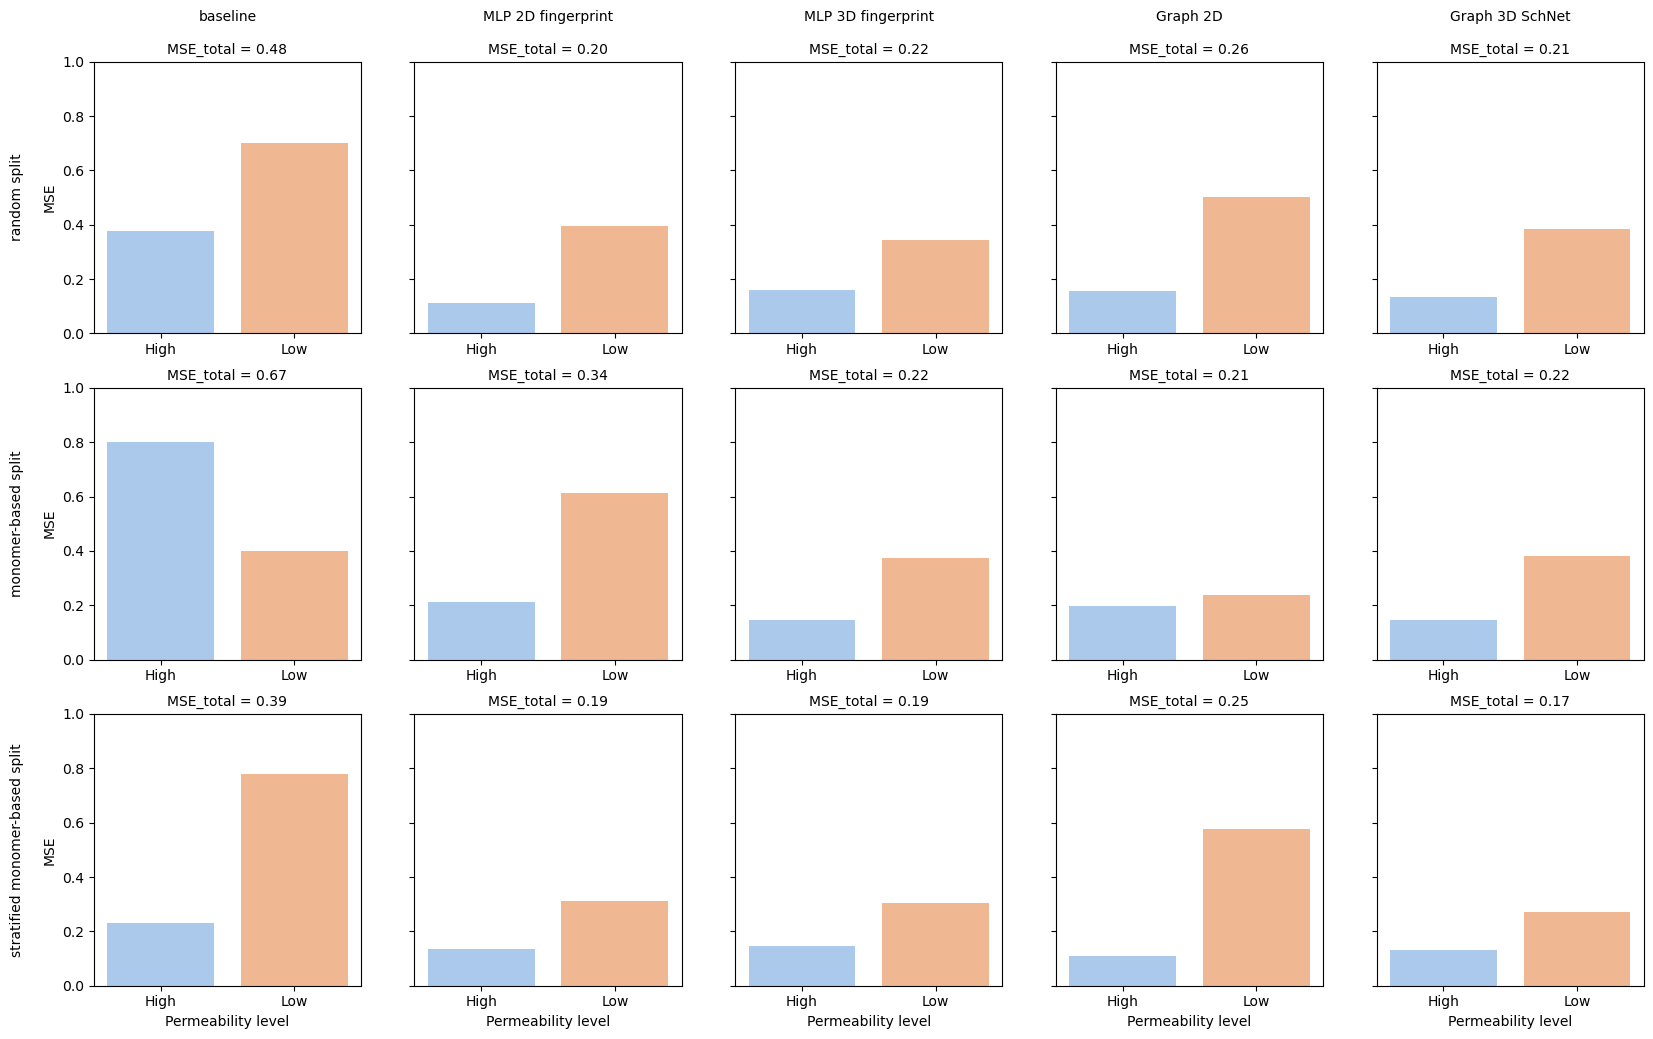

In [8]:
splits = results_df['Split'].unique()
models = results_df['Model'].unique()
permeability_levels = ['MSE_high','MSE_low']

fig, axes = plt.subplots(len(splits), len(models), figsize=(4 * len(models), 4 * len(splits)), sharey=True)

for i, split in enumerate(splits):
    for j, model in enumerate(models):
        ax = axes[i, j] if len(splits) > 1 else axes[j]  # handle 1-row case
        row = results_df[(results_df['Split'] == split) & (results_df['Model'] == model)]
        if row.empty:
            continue
        values = [row.iloc[0][lvl] for lvl in permeability_levels]
        mse = row.iloc[0]["MSE_total"]
        
        sns.barplot(x=['High', 'Low'], y=values, ax=ax, palette='pastel')
        ax.set_xlabel('')
        ax.set_ylabel('MSE' if j == 0 else '')
        ax.set_ylim(0,1)

        # Compute MSE
        if i == 0:
            ax.set_title(f"{model}\n\nMSE_total = {mse:.2f}", fontsize=10)
        else:
            ax.set_title(f"MSE_total = {mse:.2f}", fontsize=10)

        # Row label (left column)
        if j == 0:
            ax.set_ylabel(f"{split}\n\nMSE", fontsize=10)
        else:
            ax.set_ylabel("")

        # X-axis label only on bottom row
        if i == len(split_list) - 1:
            ax.set_xlabel("Permeability level", fontsize=10)
        else:
            ax.set_xlabel("")
plt.show()

Further analysis by quantile cut: Q1 is the least permeability peptide

/tmp/ipykernel_2904288/3260445550.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_labels, y=values, ax=ax, palette='pastel')
/tmp/ipykernel_2904288/3260445550.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_labels, y=values, ax=ax, palette='pastel')
/tmp/ipykernel_2904288/3260445550.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_labels, y=values, ax=ax, palette='pastel')
/tmp/ipykernel_2904288/3260445550.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0

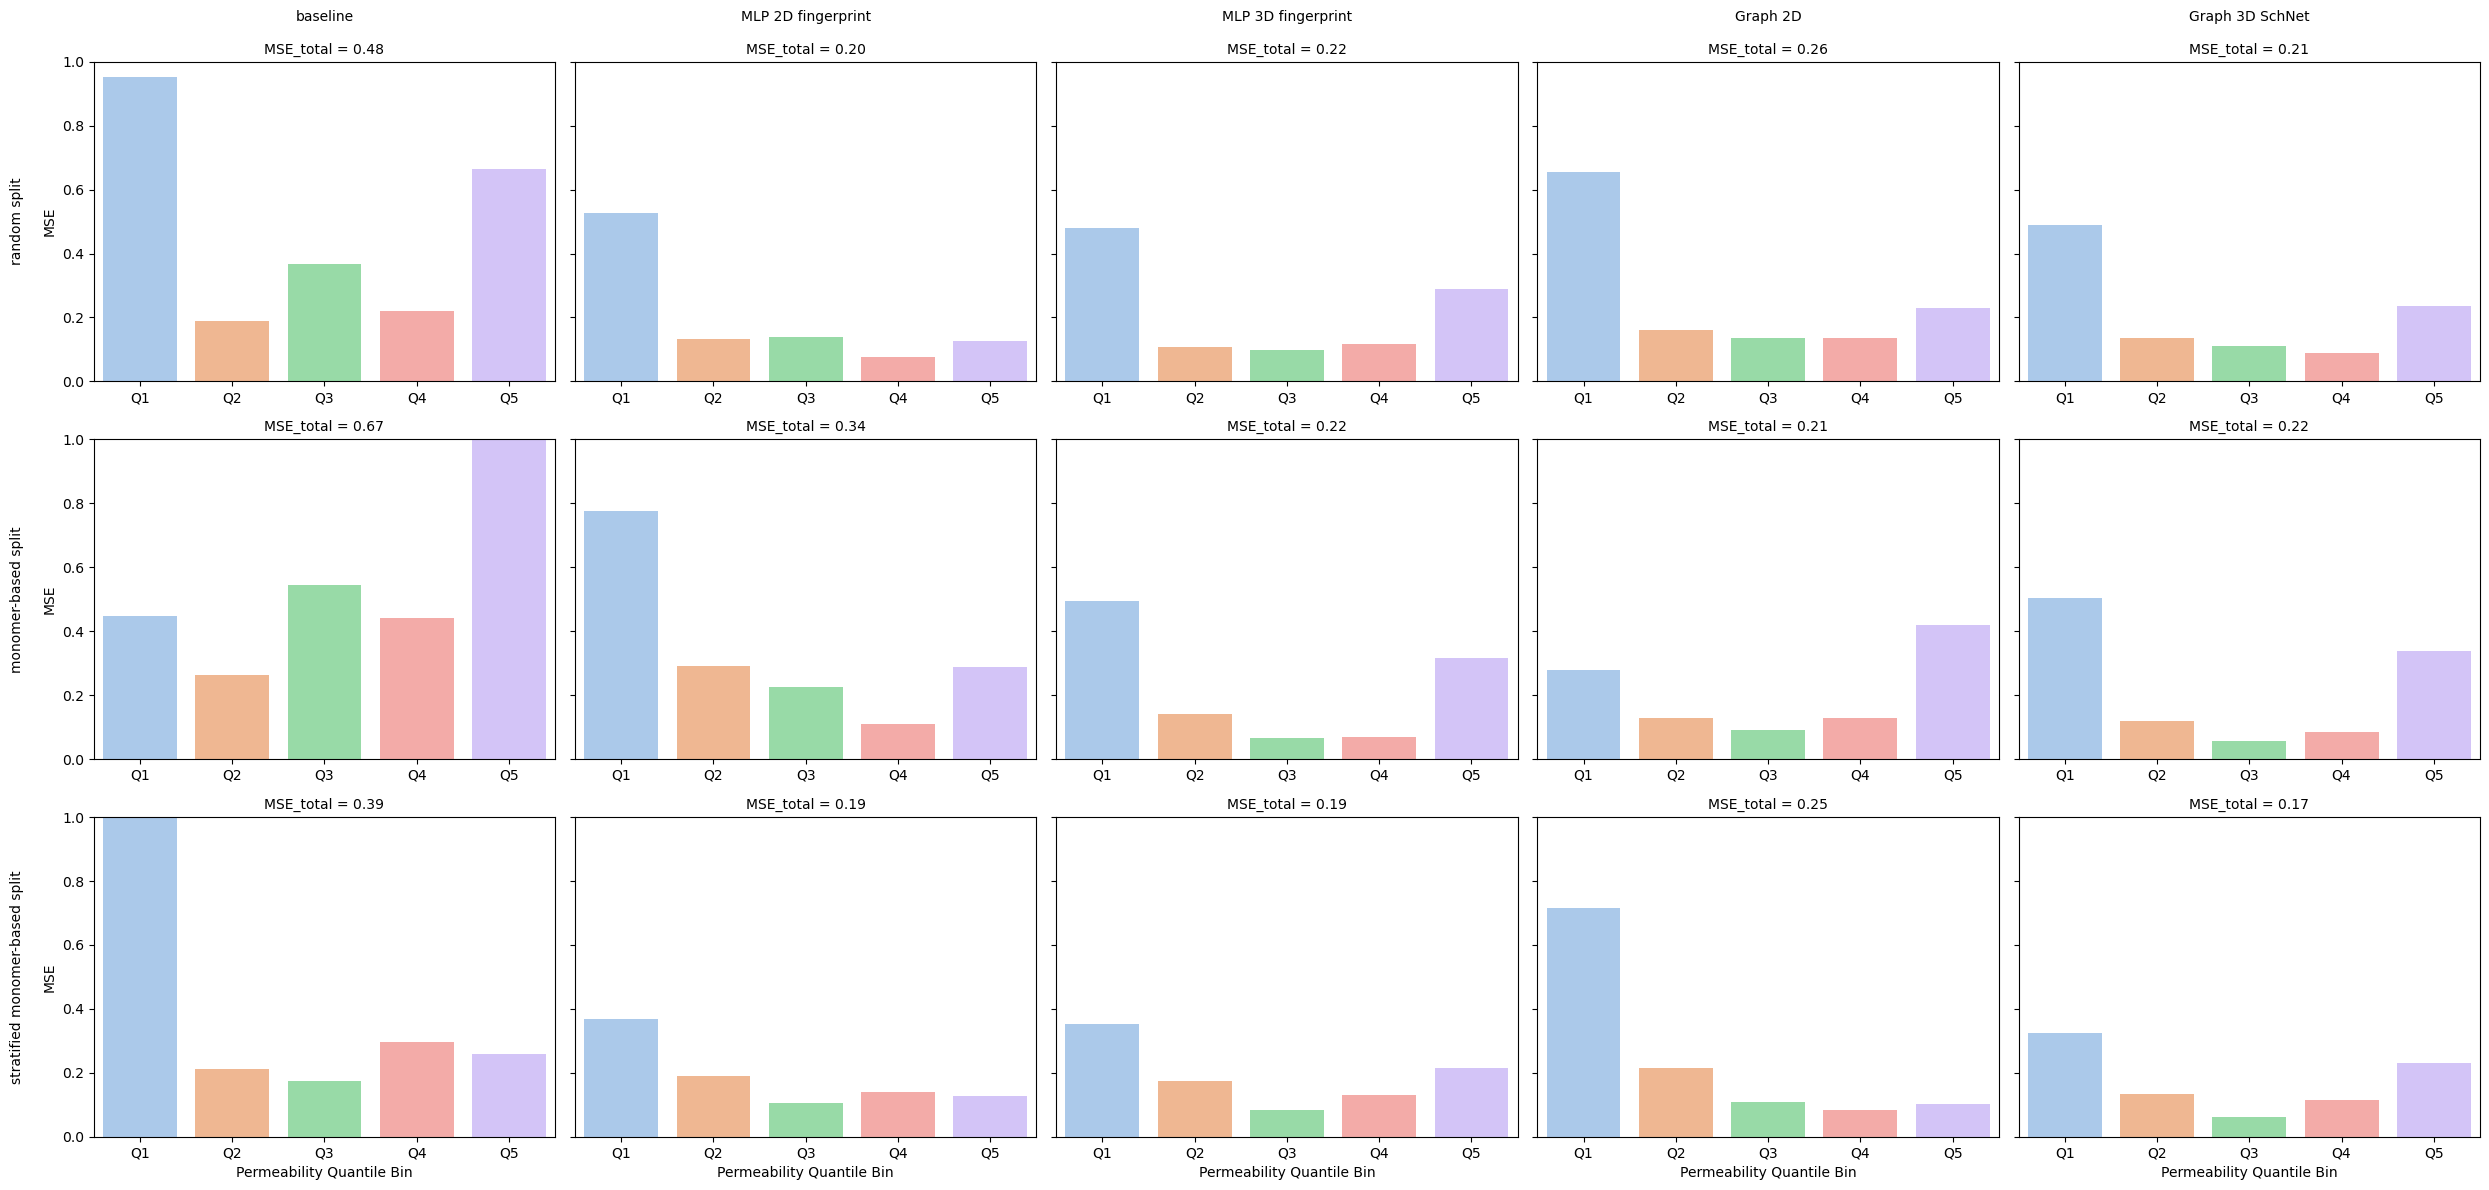

In [9]:
def load_ypred(model, split):
    pred_path = f"../results/{model}/{split}/test_predict.csv"
    df_pred = pd.read_csv(pred_path)
    y_pred = df_pred["predict_permeability"]
    return y_pred

def load_ytrue(split):
    raw_path = f"../data/{split}/raw/raw_test.csv"
    df_raw = pd.read_csv(raw_path)
    return df_raw["permeability"]

results = []
n_bins = 5
bin_labels = [f'Q{i+1}' for i in range(n_bins)]

for split in split_list:
    y_true = load_ytrue(split)
    y_true = np.array(y_true)

    # Compute bin edges once per split
    quantile_edges = np.quantile(y_true, np.linspace(0, 1, n_bins + 1))
    bin_indices = np.digitize(y_true, quantile_edges[1:-1], right=True)

    for model in model_list:
        y_pred = load_ypred(model, split)
        y_pred = np.array(y_pred)

        mse_total = mean_squared_error(y_true, y_pred)

        mse_bins = []
        for i in range(n_bins):
            mask = bin_indices == i
            if np.any(mask):
                mse_bin = mean_squared_error(y_true[mask], y_pred[mask])
            else:
                mse_bin = np.nan
            mse_bins.append(mse_bin)

        result_entry = {
            "Model": model,
            "Split": split,
            "MSE_total": mse_total
        }
        for label, mse in zip(bin_labels, mse_bins):
            result_entry[label] = mse
        results.append(result_entry)

results_df = pd.DataFrame(results)

# Plotting
splits = results_df['Split'].unique()
models = results_df['Model'].unique()

fig, axes = plt.subplots(len(splits), len(models), figsize=(5 * len(models), 4 * len(splits)), sharey=True)

for i, split in enumerate(splits):
    for j, model in enumerate(models):
        ax = axes[i, j] if len(splits) > 1 else axes[j]
        row = results_df[(results_df['Split'] == split) & (results_df['Model'] == model)]
        if row.empty:
            continue
        values = [row.iloc[0][label] for label in bin_labels]
        mse = row.iloc[0]["MSE_total"]

        sns.barplot(x=bin_labels, y=values, ax=ax, palette='pastel')
        ax.set_xlabel('')
        ax.set_ylabel('MSE' if j == 0 else '')
        ax.set_ylim(0, 1)

        if i == 0:
            ax.set_title(f"{model}\n\nMSE_total = {mse:.2f}", fontsize=10)
        else:
            ax.set_title(f"MSE_total = {mse:.2f}", fontsize=10)

        if j == 0:
            ax.set_ylabel(f"{split}\n\nMSE", fontsize=10)
        else:
            ax.set_ylabel("")

        if i == len(split_list) - 1:
            ax.set_xlabel("Permeability Quantile Bin", fontsize=10)

plt.tight_layout()
plt.show()